# Code for ANPR + OCR
Import Modules

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
import glob
import imutils
import pytesseract
import math
import numpy as np

Extracting Frames from Video

In [2]:
capture_images = False
frames_path = r'\vid3_Frames'
image_paths = glob.glob("vid3_Frames/*.jpg")
print("Found %i images..."%(len(image_paths)))

if capture_images:
    cap = cv2.VideoCapture('vid3.mp4')

    # Check if camera opened successfully
    if (cap.isOpened()== False): 
        print("Error opening video")

    # Read until video is completed
    i=0
    while(cap.isOpened()):
        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            # Display the resulting frame
            cv2.imwrite(os.path.join(frames_path, 'Frame'+str(i)+'.jpg'), frame)
            i += 1
        # Break the loop
        else: 
            break
    # When everything done, release the video capture object
    cap.release()

Found 1207 images...


Load trained WpodNet model for Plate prediction

In [4]:
# Try to recognize the plate using WPOD - pretrained weights
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


- Image Pre-processing: Rotate & crop image to consider only pixels in which number plate is clearly visible into consideration
- Run image through Wpod model
- Run results through bbox & plot it upon the frame

In [8]:

def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = imutils.rotate_bound(img, 12)
    img = img[480:1220,480:1640]
    img = img / 255
    if resize:
        img = cv2.resize(img, (224*3,224*3))
    return img

def get_plate(image_path, Dmax=608, Dmin=256):
    vehicle = preprocess_image(image_path) 
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return LpImg, cor


# Pass Image through model
def draw_box(image_path, cor, thickness=3): 
    pts=[]  
    x_coordinates=cor[0][0]
    y_coordinates=cor[0][1]
    # store the top-left, top-right, bottom-left, bottom-right 
    # of the plate license respectively
    for i in range(4):
        pts.append([int(x_coordinates[i]),int(y_coordinates[i])])
    
    pts = np.array(pts, np.int32)
    pts = pts.reshape((-1,1,2))
    vehicle_image = preprocess_image(image_path)
    
    cv2.polylines(vehicle_image,[pts],True,(0,255,0),thickness)
    return vehicle_image

Run functions for plate detection

Detect 1 plate(s) in Frame255


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


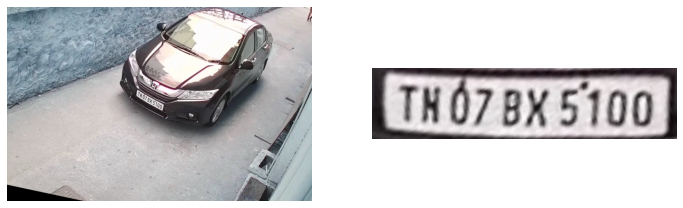

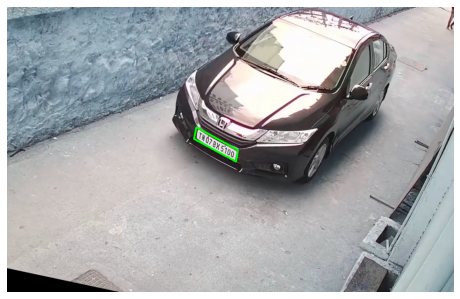

In [12]:
test_image = r'vid3_Frames/Frame255.jpg' # image_paths[750] #381
LpImg,cor = get_plate(test_image)
print("Detect %i plate(s) in"%len(LpImg),splitext(basename(test_image))[0])
# print("Coordinate of plate(s) in image: \n", cor)

# Visualize our result
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(preprocess_image(test_image))
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(LpImg[0])

plt.figure(figsize=(8,8))
plt.axis(False)
plt.imshow(draw_box(test_image,cor))

Crop out plate & run through Tesseract OCR

THO7 BX 5100



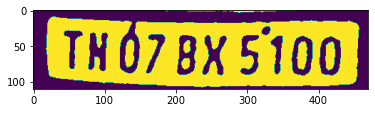

In [25]:
number_plate = (LpImg[0])*255
cv2.imwrite("number_plate.jpg",number_plate)

number_plate = cv2.imread('number_plate.jpg')
gray_img = cv2.cvtColor(number_plate, cv2.COLOR_BGR2GRAY)
thresh_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
plt.figure()
plt.imshow(thresh_img)

pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
custom_config = r'--oem 3 --psm 6'
tess = pytesseract.image_to_string(thresh_img, config=custom_config)
print(tess)

Get Text & Pass through Regex based logic to validate recognition

In [47]:
import re

tess_joint = tess.replace(" ", "")

regex = r"\w{2}\d{2}\w{2}\d{4}"
matches = re.search(regex, tess_joint)

if not matches:
    print(tess, ':- Number Plate not valid. Manual intervention required')

THO7 BX 5100
 :- Number Plate not valid. Manual intervention required
